# Statistical inference of stock returns with linear regression

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['open', 'close', 'low', 'high'], axis=1))

### Select Investment Universe

In [7]:
data = data[data.dollar_vol_rank<100] #选取日现金交易量位于前100的股票为研究对象

In [6]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 65 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_low                 109675 non-null  float64
 7   atr                    109675 non-null  float64
 8   macd                   109675 non-null  float64
 9   return_1d              109675 non-null  float64
 10  return_5d              109675 non-null  float64
 11  return_10d             109675 non-null  float64
 12  return_21d             109675 non-null  float64
 13  return_42d    

### Create Model Data

In [8]:
y = data.filter(like='target') #筛选出名字里含target的列
y

target_1d  target_5d  target_10d  target_21d
ticker date                                                    
AAL    2013-07-25   0.013808   0.005775    0.000794   -0.007255
       2013-07-26   0.007334  -0.001787   -0.002597   -0.007757
       2013-07-29  -0.001560  -0.000625   -0.002153   -0.010307
       2013-07-30   0.007813  -0.002934   -0.015880   -0.010631
       2013-07-31   0.001550  -0.005011   -0.017793   -0.009130
...                      ...        ...         ...         ...
ZTS    2014-11-28  -0.012464  -0.004265   -0.007266   -0.001703
       2014-12-01   0.008339  -0.001220   -0.006092   -0.001459
       2014-12-02   0.003129  -0.004147   -0.009055   -0.001546
       2014-12-03  -0.019608  -0.009585   -0.008687   -0.001980
       2014-12-04  -0.000455  -0.005144   -0.001949   -0.001505

[109675 rows x 4 columns]

In [34]:
X = data.drop(y.columns, axis=1) #不要名字里含target的列
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1) #删去这些列
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 57 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   dollar_vol_1m          109675 non-null  float64
 1   rsi                    109675 non-null  float64
 2   bb_high                109675 non-null  float64
 3   bb_low                 109675 non-null  float64
 4   atr                    109675 non-null  float64
 5   macd                   109675 non-null  float64
 6   return_1d              109675 non-null  float64
 7   return_5d              109675 non-null  float64
 8   return_10d             109675 non-null  float64
 9   return_21d             109675 non-null  float64
 10  return_42d             109675 non-null  float64
 11  return_63d             109675 non-null  float64
 12  return_1d_lag1         109675 non-null  float64
 13  return_5d_lag1

## Explore Data

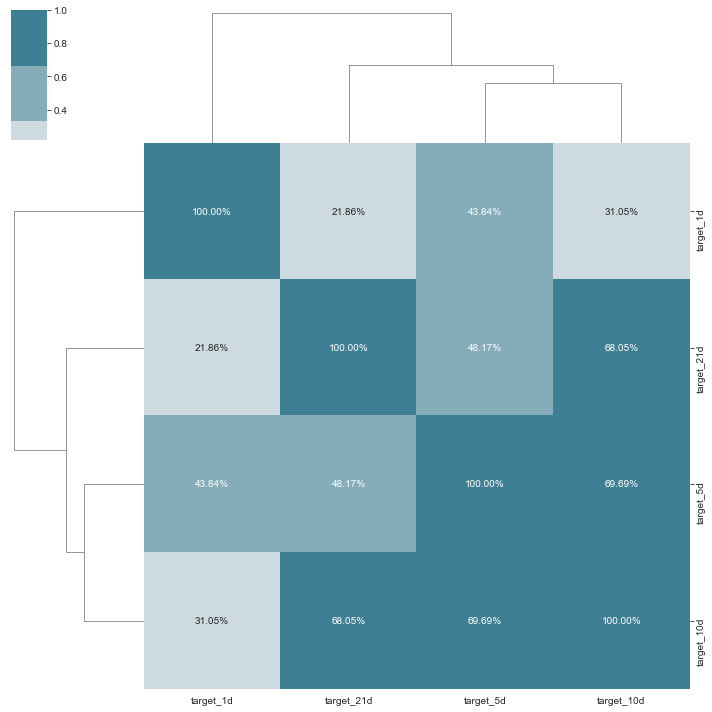

In [15]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');
#sns.clustermap绘制聚类图
#y.corr()构建y中所含变量的相关系数矩阵
#cmap：从数字到色彩空间的映射，取值是matplotlib包里的colormap名称或颜色对象，或者表示颜色的列表；改参数默认值：根据center参数设定
#center：数据表取值有差异时，设置热力图的色彩中心对齐值；通过设置center值，可以调整生成的图像颜色的整体深浅；设置center数据时，如果有数据溢出，则手动设置的vmax、vmin会自动改变
#annot(annotate的缩写)：默认取值False；如果是True，在热力图每个方格写入数据；如果是矩阵，在热力图每个方格写入该矩阵对应位置数据。
#fmt：字符串格式代码，矩阵上标识数字的数据格式，比如保留小数点后几位数字。

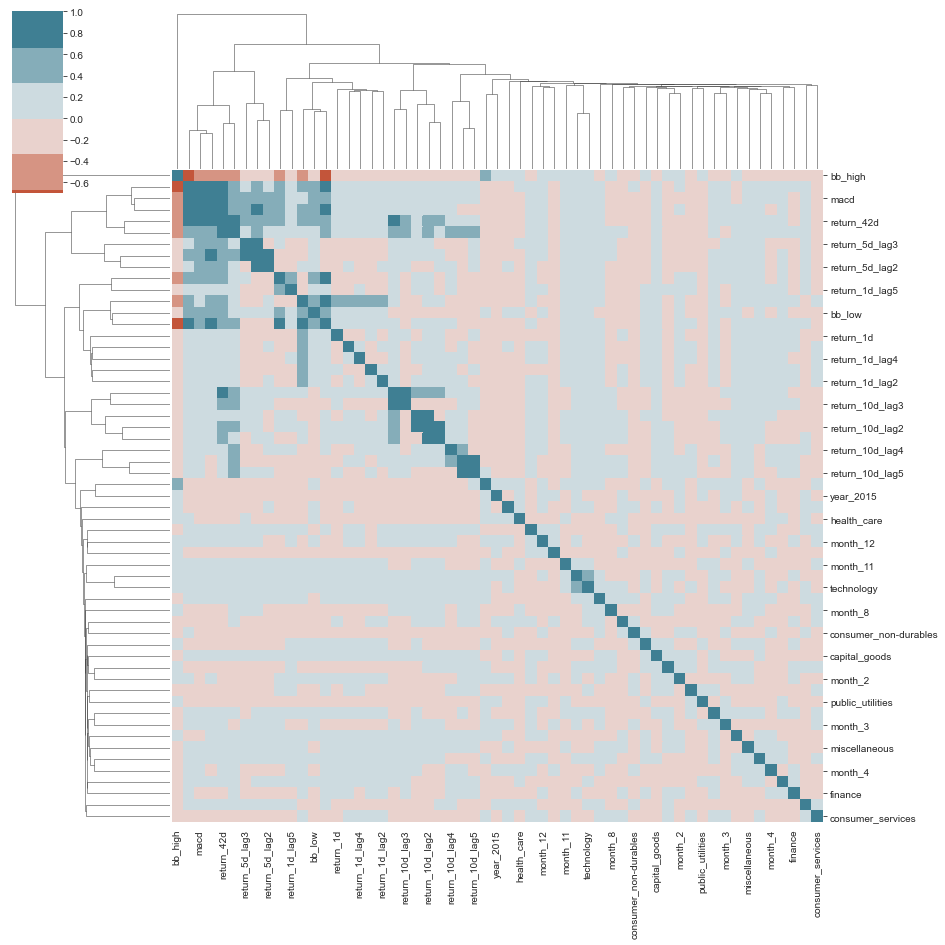

In [14]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

In [16]:
corr_mat = X.corr().stack().reset_index() #.stack使dataframe化为series
corr_mat.columns=['var1', 'var2', 'corr'] #var不是方差而是variable的简称
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False) #去除自己与自己的相关系数，按降序排列

In [22]:
corr_mat

,var1,var2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
518,return_21d,macd,0.793893
...,...,...,...
515,return_21d,bb_high,-0.632777
122,bb_high,return_10d,-0.693640
458,return_10d,bb_high,-0.693640
59,rsi,bb_high,-0.696555


In [11]:
corr_mat.head().append(corr_mat.tail()) #显示相关系数最大与最小的数据

,var1,var2,corr
581,return_42d,return_63d,0.835634
637,return_63d,return_42d,0.835634
286,macd,rsi,0.817113
62,rsi,macd,0.817113
518,return_21d,macd,0.793893
515,return_21d,bb_high,-0.632777
122,bb_high,return_10d,-0.693640
458,return_10d,bb_high,-0.693640
59,rsi,bb_high,-0.696555
115,bb_high,rsi,-0.696555


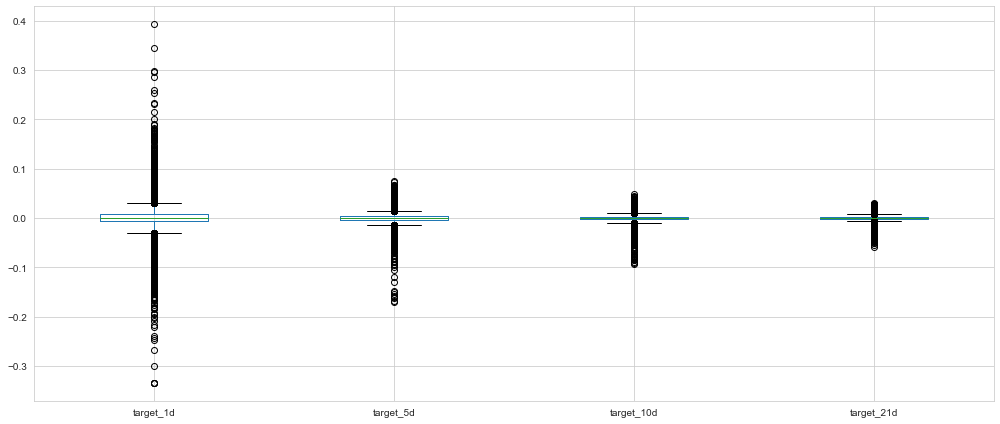

In [25]:
y.boxplot(figsize=(14, 6))
plt.tight_layout()

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [35]:
sectors = X.iloc[:, -10:] #sectors对应的是行业虚拟变量
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='ticker')
     .transform(lambda x: (x - x.mean()) / x.std()) #按ticker为分组进行标准化
    .join(sectors) #再加入行业虚拟变量
    .fillna(0))

### 1-Day Returns

In [36]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X)) #注意，给X加了常数项
trained_model = model.fit()
print(trained_model.summary())
#拒绝残差项服从正态分布
#认为残差之间不存在自相关性

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     19.03
Date:                Mon, 31 Oct 2022   Prob (F-statistic):          9.43e-189
Time:                        14:58:45   Log-Likelihood:             2.8852e+05
No. Observations:              109675   AIC:                        -5.769e+05
Df Residuals:                  109617   BIC:                        -5.764e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### 5-Day Returns

In [37]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())
#拒绝残差项服从正态分布
#认为残差之间存在正的自相关性

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     61.86
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:02:07   Log-Likelihood:             3.7883e+05
No. Observations:              109675   AIC:                        -7.575e+05
Df Residuals:                  109617   BIC:                        -7.570e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

#### Obtain the residuals

In [38]:
preds = trained_model.predict(add_constant(X)) #此可以理解为y_hat
residuals = y[target] - preds

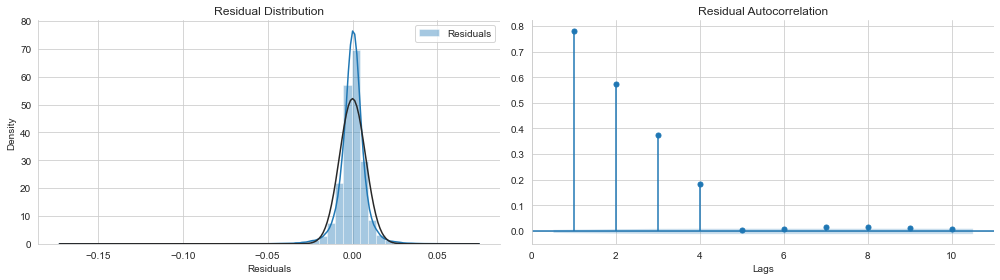

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend() #设置图例
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation') #绘制自相关函数
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();

### 10-Day Returns

In [45]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())
#拒绝残差项服从正态分布
#认为残差之间存在正的自相关性

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     85.38
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:12:00   Log-Likelihood:             4.1892e+05
No. Observations:              109675   AIC:                        -8.377e+05
Df Residuals:                  109617   BIC:                        -8.372e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

### Monthly Returns

In [46]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())
#拒绝残差项服从正态分布
#认为残差之间存在正的自相关性

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     119.7
Date:                Mon, 31 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:13:20   Log-Likelihood:             4.6155e+05
No. Observations:              109675   AIC:                        -9.230e+05
Df Residuals:                  109617   BIC:                        -9.224e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00